In [1]:
import numpy as np
import torch

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.optim.data_fidelity import L2
from deepinv.utils.demo import load_url_image, get_image_url
from tqdm import tqdm  # to visualize progress

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

url = get_image_url("butterfly.png")
img_size = 256
x_true = load_url_image(url=url, img_size=img_size).to(device)
x = x_true.clone()

/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Selected GPU 0 with 24124 MB free memory 


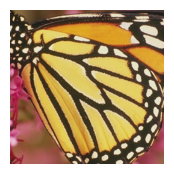

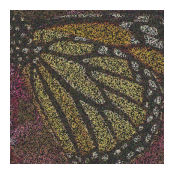

In [95]:
sigma = 0.1  # noise level

hole_size = 60
mask = 0.5
# mask = torch.ones(img_size, img_size)
# mask[(img_size - hole_size)//2:(img_size + hole_size)//2, (img_size - hole_size)//2:(img_size + hole_size)//2] = torch.zeros(hole_size, hole_size)
# mask.to(device)
physics = dinv.physics.Inpainting(
    mask=mask,
    tensor_size=x.shape[1:],
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=sigma),
)
# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(0)

# load Gaussian Likelihood
likelihood = dinv.optim.L2(sigma=sigma)

sigma_denoiser = 0.01#3 / 255
prior = dinv.optim.ScorePrior(
    denoiser=dinv.models.DnCNN(pretrained="download_lipschitz")
    #denoiser=dinv.models.DiffUNet(large_model=False)
).to(device)

y = physics(x)
plot(x_true.detach().cpu())
plot(y)

In [96]:
class PMCPnPIterator(torch.nn.Module):
    def __init__(self, gamma, sigma, alpha=1):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.noise_std = np.sqrt(2 * gamma)
        self.sigma = sigma
        self.iter = 0

    def forward(self, x, y, physics, likelihood, prior):
        self.iter += 1
        noise = torch.randn_like(x) * self.noise_std
        lhood = - likelihood.grad(x, y, physics)
        lprior = - prior(x - (self.gamma * lhood), self.sigma) * self.alpha
        return x + self.gamma * (lhood + lprior) + noise
        
class PMCPnP(dinv.sampling.MonteCarlo):
    def __init__(
        self, prior, data_fidelity, sigma, gamma, alpha, max_iter=1e3, thinning=1, burnin_ratio=0.4, clip=(0, 1), verbose=True,
    ):
        # generate an iterator
        iterator = PMCPnPIterator(gamma=gamma, sigma=sigma, alpha=alpha)
        # set the params of the base class
        super().__init__(
            iterator, prior, data_fidelity, max_iter=max_iter, thinning=thinning, burnin_ratio=burnin_ratio, clip=clip, verbose=verbose,
        )

In [97]:
gamma = 1.e-4
alpha = 1
iterations = int(2e3) if torch.cuda.is_available() else 10


pmc_pnp = PMCPnP(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigma=sigma_denoiser,
                 alpha=alpha,)




In [98]:

pula_mean, pula_var = pmc_pnp(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

100%|██████████| 2000/2000 [00:11<00:00, 179.90it/s]

Monte Carlo sampling finished! elapsed time=11.17 seconds
Iteration 1999, current converge crit. = 1.03E-04, objective = 1.00E-03 
Iteration 1999, current converge crit. = 7.88E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 8.40 dB
PreconULA posterior mean PSNR: 21.76 dB


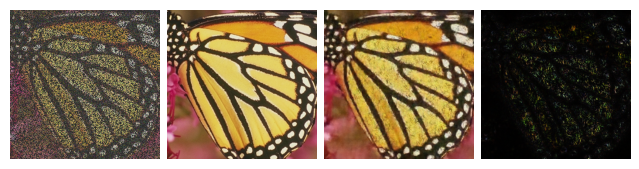

In [99]:
# plot results
imgs = [x_lin, x, pula_mean, pula_var]
plot(imgs)

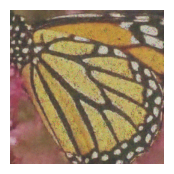

In [103]:
example_sample = pula_mean + torch.randn_like(pula_mean) * torch.sqrt(pula_var)

plot(example_sample)

In [105]:
class PMCPnPAnnealingIterator(torch.nn.Module):
    def __init__(self, gamma, sigmas, alphas=torch.ones(1000), max_iter=1e3):
        super().__init__()
        self.gamma = gamma
        self.alphas = alphas
        self.noise_std = np.sqrt(2 * gamma)
        self.sigmas = sigmas
        self.iter = 0
        self.max_iter = max_iter

    def forward(self, x, y, physics, likelihood, prior):
        noise = torch.randn_like(x) * self.noise_std
        lhood = - likelihood.grad(x, y, physics)
        lprior = - prior(x - (self.gamma * lhood), self.sigmas[self.iter]) * self.alphas[self.iter]
        self.iter = (self.iter + 1) % self.max_iter
        return x + self.gamma * (lhood + lprior) + noise
        
class PMCPnPAnnealing(dinv.sampling.MonteCarlo):
    def __init__(
        self, prior, data_fidelity, sigmas, gamma, alphas, max_iter=1e3, thinning=1, burnin_ratio=0.4, clip=(0, 1), verbose=True,
    ):
        # generate an iterator
        iterator = PMCPnPAnnealingIterator(gamma=gamma, sigmas=sigmas, alphas=alphas, max_iter=max_iter)
        # set the params of the base class
        super().__init__(
            iterator, prior, data_fidelity, max_iter=max_iter, thinning=thinning, burnin_ratio=burnin_ratio, clip=clip, verbose=verbose,
        )

In [119]:
iterations = int(2e3) if torch.cuda.is_available() else 10
gamma = 1.e-4

horizon = 2000
base_alpha = 3
alphas = torch.Tensor([max(base_alpha - (i * (base_alpha - 1)/horizon), 1) for i in range(iterations)])
base_sigma = 0.1
min_sigma = 0.01
sigmas = torch.Tensor([max(base_sigma - (i * (base_sigma - min_sigma)/horizon), min_sigma) for i in range(iterations)])


pmc_pnp = PMCPnPAnnealing(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigmas=sigmas,
                 alphas=alphas,)




100%|██████████| 2000/2000 [00:11<00:00, 181.42it/s]


Monte Carlo sampling finished! elapsed time=11.07 seconds
Iteration 1999, current converge crit. = 2.63E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 8.40 dB
PreconULA posterior mean PSNR: 12.81 dB


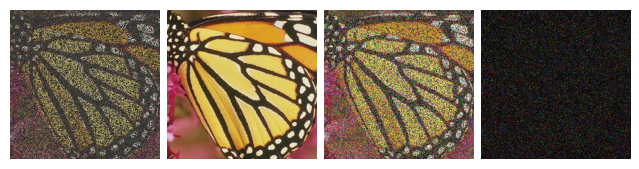

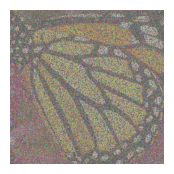

In [120]:

pula_mean, pula_var = pmc_pnp(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

# plot results
imgs = [x_lin, x, pula_mean, pula_var]
plot(imgs)
example_sample = pula_mean + torch.randn_like(pula_mean) * torch.sqrt(pula_var)

plot(example_sample)
